## Sentence Modality Notebook

### Imported libraries

In [1]:
%matplotlib notebook
from nlpcore import *
import tensorflow as tf
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense
from keras.callbacks import TensorBoard,ModelCheckpoint,Callback
from keras import backend as K

Using TensorFlow backend.


In [2]:
dl_PATH = './downloads/'

### Functions for downloading and unzipping modality data
All data is saved to the downloads file so as to not be uploaded to github.

In [3]:
maybe_download('http://rgai.inf.u-szeged.hu/~vinczev/conll2010st/task1_train_bio_rev2.zip', 'task1_train_bio.zip', dl_PATH)
maybe_unzip('task1_train_bio.zip', dl_PATH) #'task1_train_bio_abstracts_rev2.xml' and 'task1_train_bio_fullarticles_rev2.xml'

task1_train_bio.zip already downloaded.
task1_train_bio.zip already unzipped.


### Class/functions definitions for handling .xml data files
The data is presented in an xml file format and is processed here into an ElementTree. The element tree behaves similarly to a nested list structure with a few extra methods.


In [4]:
data = TextData('task1_train_bio_abstracts_rev2.xml')    

In [5]:
sentences = data.get_sentences()
sentence_lengths = []
total = 0
for sentence in toStrings(sentences):
    sentence_lengths.append(num_words(sentence))
    total += 1
print(total)

11871


<IPython.core.display.Javascript object>


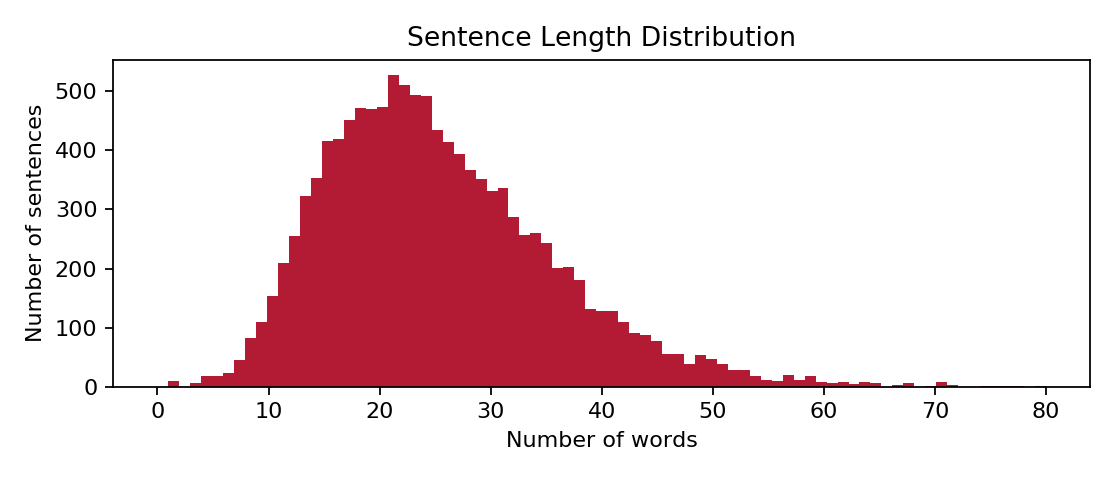

In [14]:
fig1 = plt.figure(figsize=(7,3))
ax1 = fig1.gca()
ax1.set_title('Sentence Length Distribution')
ax1.set_ylabel('Number of sentences')
ax1.set_xlabel('Number of words')
plt.hist(sentence_lengths,bins=81,range=(0,80),color=[0.7,0.1,0.2])
plt.tight_layout()
plt.show()

In [7]:
embed_dict=import_embedding('./logs/word2vec_label.tsv')

<IPython.core.display.Javascript object>


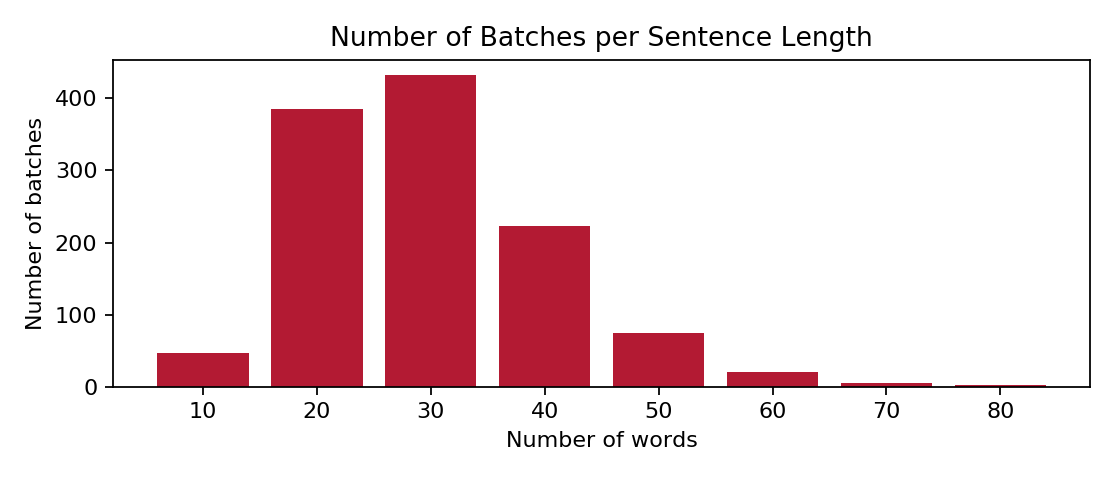

In [15]:
batches = generate_batches(sentences,80,10,embed_dict,show_hist=True)
train=batches[:500]+batches[600:]
test=batches[500:600]
rd.shuffle(test)
rd.shuffle(train)

In [16]:
vocab_size = 5000
embedding_dimension = 32
batch_size = 10

In [17]:
model = Sequential()
model.add(Embedding(vocab_size,embedding_dimension,name='word2vec',trainable=True))
model.add(LSTM(30, 
               activation='tanh', # activation function used
               recurrent_activation='hard_sigmoid', # activation function for recurrent step
               use_bias=True, # whether the layer uses a bias vector
               kernel_initializer='glorot_uniform', # initialiser for the weights matrix
               recurrent_initializer='orthogonal', # initialiser for the recurrent kernal's weights
               bias_initializer='zeros', # initialiser for the bias vector
               unit_forget_bias=True, # add 1 to the bias of the forget gate at initialization
               kernel_regularizer=None, # regularizer function applied to kernal
               recurrent_regularizer=None, # regularizer function applied to recurrent kernal
               bias_regularizer=None, # regularizer function applied to bias vector
               activity_regularizer=None, # regularizer function applied to output of the layer
               kernel_constraint=None, # constraint function applied to the kernal
               recurrent_constraint=None, # constraint function applied to the recurrent kernal
               bias_constraint=None, # constraint function applied to the bias vector
               dropout=0.0, # fraction of units to drop for the linear transformation of the inputs
               recurrent_dropout=0.0, # fraction of units to drop for the linear transformation of the recurrent state
               implementation=1, # implementation mode, either 1 or 2.
               return_sequences=False, 
               return_state=False, 
               go_backwards=False, 
               stateful=False, # If True, the last state for each sample at index i in a batch will be used as initial state for the sample of index i in the following batch.
               unroll=False)) # whether the network will be unrolled, otherwise a symbolic loop will be used.
model.add(Dense(2,
                activation='softmax', 
                use_bias=True, 
                kernel_initializer='glorot_uniform', 
                bias_initializer='zeros', 
                kernel_regularizer=None, 
                bias_regularizer=None, 
                activity_regularizer=None, 
                kernel_constraint=None, 
                bias_constraint=None))
model.compile(optimizer='RMSprop', 
              loss='categorical_crossentropy', 
              metrics=['acc'], 
              sample_weight_mode=None, 
              weighted_metrics=None, 
              target_tensors=None)
model.load_weights('./logs/wordvec_model.h5',by_name=True)
model.summary()
plot_model(model, to_file='./images/modalityLSTMmodel.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word2vec (Embedding)         (None, None, 32)          160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7560      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 62        
Total params: 167,622
Trainable params: 167,622
Non-trainable params: 0
_________________________________________________________________


### LSTM Model
![Graph of LSTM Model](./images/modalityLSTMmodel.png)

In [11]:
TC = TensorBoard(log_dir='./logs/modality', batch_size=batch_size, 
                          histogram_freq=0, write_images=True, 
                          write_grads=False, write_graph=True, embeddings_freq=1)
model_checkpoint = ModelCheckpoint('./logs/modalityLSTMmodel.h5')

In [12]:
vX = test[0][0]
vY = test[0][1]
for batch in test[1:]:
    vX = np.append(vX,batch[0],axis=0)
    vY = np.append(vY,batch[1],axis=0)

In [13]:
epoch=0
TC.set_model(model)
TC.validation_data=(vX,vY)
for batch in train:
    [x,y] = batch
    [loss, acc] = model.train_on_batch(x,y)
    [val_loss,val_acc] = model.test_on_batch(vX,vY)
    logs = {'acc': acc, 'loss': loss, 'val_loss': val_loss, 'val_acc': val_acc}
    TC.on_epoch_end(epoch, logs)
    epoch += 1
    if epoch%50 == 0:
        print('Epoch: %d'%(epoch))

TC.on_train_end(_)

NameError: name 'epoch' is not defined

In [ ]:
y_true = []
y_pred = []
for batch in batches:
    for ys in batch[1]:
        y_true.append(np.argmax(ys))
    for ys in model.predict(batch[0]):
        y_pred.append(np.argmax(ys))

In [ ]:
cm = confusion_matrix(y_true,y_pred)
cm2 = normalize(cm,axis=1,norm='l1')

In [ ]:
conf_matrix(y_true, y_pred)

![Validation Data Accuracy](./images/val_acc_01.png)
![Validation Data loss](./images/val_loss_01.png)